In [2]:
import pandas as pd
import numpy as np

In [3]:
# Datasets with frequences of combinations (3,4,5 drugs in a combination)
dataset_3comb = pd.read_csv('doi_10_5061_dryad_sm847__v20181016/db_drugs_3s.tsv', sep='\t')
dataset_4comb = pd.read_csv('doi_10_5061_dryad_sm847__v20181016/db_drugs_4s.tsv', sep='\t')
dataset_5comb = pd.read_csv('doi_10_5061_dryad_sm847__v20181016/db_drugs_5s.tsv', sep='\t')
dataset_3comb['drug_names'] = dataset_3comb[['drug_name_A', 'drug_name_B', 'drug_name_C']].values.tolist()
dataset_4comb['drug_names'] = dataset_4comb[['drug_name_A', 'drug_name_B', 'drug_name_C', 'drug_name_D']].values.tolist()
dataset_5comb['drug_names'] = dataset_5comb[['drug_name_A', 'drug_name_B', 'drug_name_C', 'drug_name_D', 'drug_name_E']].values.tolist()

In [4]:
# Dataset with specififc patient and their combination (contains only 40 distinct drugs)
data = pd.read_csv('refined_drug_data.csv', sep=';')
data = data.fillna('')
# Aggregate all drugs in one column
data['drug_names'] = data[['Drug_1', 'Drug_2', 'Drug_3', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_8']].values.tolist()
data['drug_names'] = data['drug_names'].apply(lambda x: [i.lower() for i in x if i])
data['drug_names']

0      [carvedilol, esomeprazole, levothyroxine, tram...
1      [amlodipine, metoprolol, omeprazole, simvastat...
2      [alendronate, atorvastatin, levothyroxine, lis...
3                    [amlodipine, losartan, simvastatin]
4      [lisinopril, metoprolol, omeprazole, sertralin...
                             ...                        
907                     [atenolol, lisinopril, warfarin]
908         [hydrochlorothiazide, lisinopril, metformin]
909    [amlodipine, glipizide, ibuprofen, levothyroxi...
910                 [albuterol, montelukast, prednisone]
911         [albuterol, citalopram, ibuprofen, tramadol]
Name: drug_names, Length: 912, dtype: object

In [6]:
IS_DEBUG = False
def print_debug(*args):
    if IS_DEBUG:
        print(*args)

For each data in data['drug_names'], check if it is present in dataset_3comb/dataset_4comb/dataset_5comb and add the corresponding exact_exposure_count.
If a combination is not found, use exact_exposure_count=1.

In [7]:
data['exact_exposure_count'] = 0
for i in range(len(data)):
    current_recept = list(data['drug_names'][i])
    print_debug(current_recept)
    current_length = len(current_recept)

    # Replace levothyroxine with thyroxine because data with frequencies contains only thyroxine
    if 'levothyroxine' in current_recept:
        current_recept[current_recept.index('levothyroxine')] = 'thyroxine'

    if current_length == 3:
        for j in range(len(dataset_3comb)):
            if set(current_recept) == set(dataset_3comb['drug_names'][j]):
                data['exact_exposure_count'][i] = dataset_3comb['exact_exposure_count'][j]
                print_debug(data['exact_exposure_count'][i])
                break
        if data['exact_exposure_count'][i] == 0:
            data['exact_exposure_count'][i] = 1
    elif current_length == 4:
        for j in range(len(dataset_4comb)):
            if set(current_recept) == set(dataset_4comb['drug_names'][j]):
                data['exact_exposure_count'][i] = dataset_4comb['exact_exposure_count'][j]
                print_debug(data['exact_exposure_count'][i])
                break
        if data['exact_exposure_count'][i] == 0:
            data['exact_exposure_count'][i] = 1
    elif current_length == 5:
        for j in range(len(dataset_5comb)):
            if set(current_recept) == set(dataset_5comb['drug_names'][j]):
                data['exact_exposure_count'][i] = dataset_5comb['exact_exposure_count'][j]
                print_debug(data['exact_exposure_count'][i])
                break
        if data['exact_exposure_count'][i] == 0:
            data['exact_exposure_count'][i] = 1
    else:
        data['exact_exposure_count'][i] = 1
        print_debug('default 1')

/var/folders/7n/k_kj6p290g53x5cs85xjv90m0000gn/T/ipykernel_12594/1152002296.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['exact_exposure_count'][i] = 1
/var/folders/7n/k_kj6p290g53x5cs85xjv90m0000gn/T/ipykernel_12594/1152002296.

In [8]:
print('Total: ', data.shape[0]) # 1/3 of capsules was not found in the dataset
print('Not found: ', data[data['exact_exposure_count'] == 1].shape[0])
print('Capsules with more than 5 drugs: ', data[data['drug_names'].apply(lambda x: len(x) > 5)].shape[0])

# 265 capsules with 3-5 drugs not found
data_without_1_occurences = data[data['exact_exposure_count'] != 1]

Total:  912
Not found:  333
Capsules with more than 5 drugs:  68


In [9]:
# data store
data.to_csv('capsules_with_freq.csv', sep=';', index=False)

In [10]:
dosages = pd.read_csv('drugs_dosing.csv', sep=';')
all_40_drugs = dosages['Drug Names'].values.tolist()
all_40_drugs = [i.lower() for i in all_40_drugs]
# all_40_drugs

In [11]:
# all_40_drugs_sorted

In [12]:
coocurrence_matrix = np.zeros((40, 40))
sorted_drug_names = data['drug_names'].explode().value_counts().index
all_40_drugs_sorted = [i for i in sorted_drug_names if i in all_40_drugs]

for i in data.iterrows():
    combination = i[1]['drug_names']
    combination_idxs = [all_40_drugs_sorted.index(drug) for drug in combination if drug in all_40_drugs_sorted]
    exact_exposure_count = 100 if i[1]['exact_exposure_count'] == '<100' else i[1]['exact_exposure_count']
    for drug1 in combination_idxs:
        for drug2 in combination_idxs:
            coocurrence_matrix[drug1][drug2] += int(exact_exposure_count)


barplot_freq_of_drug = np.zeros(40)
all_the_drugs = []
for i in data.iterrows():
    combination = i[1]['drug_names']

    combination_idxs = [all_40_drugs_sorted.index(drug) for drug in combination if drug in all_40_drugs_sorted]
    all_the_drugs += combination_idxs
    
    exact_exposure_count = 100 if i[1]['exact_exposure_count'] == '<100' else i[1]['exact_exposure_count']
    for drug in combination:
        if drug in all_40_drugs:
            barplot_freq_of_drug[all_40_drugs.index(drug)] += int(exact_exposure_count)
barplot_freq_of_drug

array([1.5443200e+05, 2.7076600e+05, 8.4339000e+04, 2.6617870e+06,
       1.2081000e+04, 1.4103990e+06, 2.8989450e+06, 1.9549400e+05,
       1.3690300e+05, 1.6646710e+06, 9.1979000e+04, 6.7155000e+04,
       2.9000000e+01, 3.3081600e+05, 2.9734000e+04, 1.1207930e+06,
       1.0440801e+07, 3.0545000e+04, 3.8616000e+04, 2.2467050e+06,
       1.6019701e+07, 7.3403000e+05, 5.1631000e+05, 5.7276050e+06,
       5.5871010e+06, 1.4221600e+05, 6.7423300e+05, 2.2759200e+05,
       7.2000000e+01, 3.2093300e+05, 6.9048000e+04, 2.9114000e+04,
       1.8261900e+05, 8.8766000e+04, 1.2818349e+07, 1.4516800e+05,
       1.9890000e+04, 3.7791800e+05, 2.6949600e+05, 7.7608000e+04])

In [13]:
# normalize the coocurrence matrix
normalized_coocurrence_matrix = coocurrence_matrix / coocurrence_matrix.sum(axis=0)

# store the coocurrence matrix
np.savetxt('normalized_coocurrence_matrix2.csv', normalized_coocurrence_matrix, delimiter=',')

In [14]:
# normalized_barplot_freq_of_drug 

In [15]:
# store  values freq barplot_freq_of_drug_sorted, all_40_drugs_sorted to file 
import pickle
with open('barplot_freq_of_drug_sorted.pkl', 'wb') as f:
    pickle.dump(barplot_freq_of_drug, f)

with open('all_40_drugs_sorted.pkl', 'wb') as f:
    pickle.dump(all_40_drugs, f)


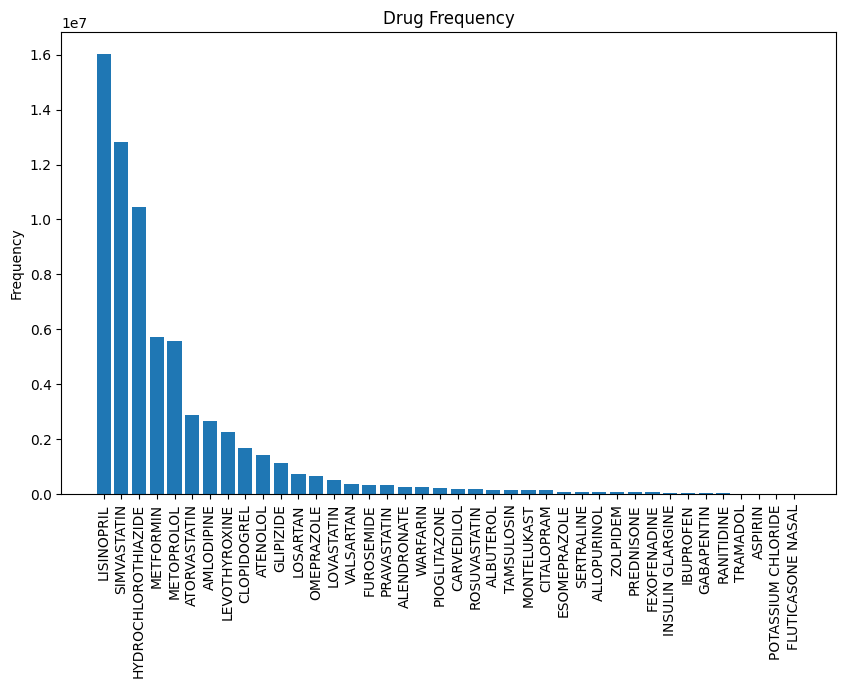

In [16]:
import matplotlib.pyplot as plt

# sort the barplot_freq_of_drug
barplot_freq_of_drug_sorted, all_40_drugs_sorted = zip(*sorted(zip(barplot_freq_of_drug, all_40_drugs), reverse=True))
all_40_drugs_sorted = [i.upper() for i in all_40_drugs_sorted]
plt.figure(figsize=(10, 6))
plt.bar(all_40_drugs_sorted, barplot_freq_of_drug_sorted)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Drug Frequency')
plt.show()

[2.83 2.26 1.84 1.01 0.99 0.51 0.47 0.4  0.29 0.25 0.2  0.13 0.12 0.09
 0.07 0.06 0.06 0.05 0.05 0.04 0.03 0.03 0.03 0.03 0.03 0.02 0.02 0.02
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.  ]
Total number of machines:  50.0


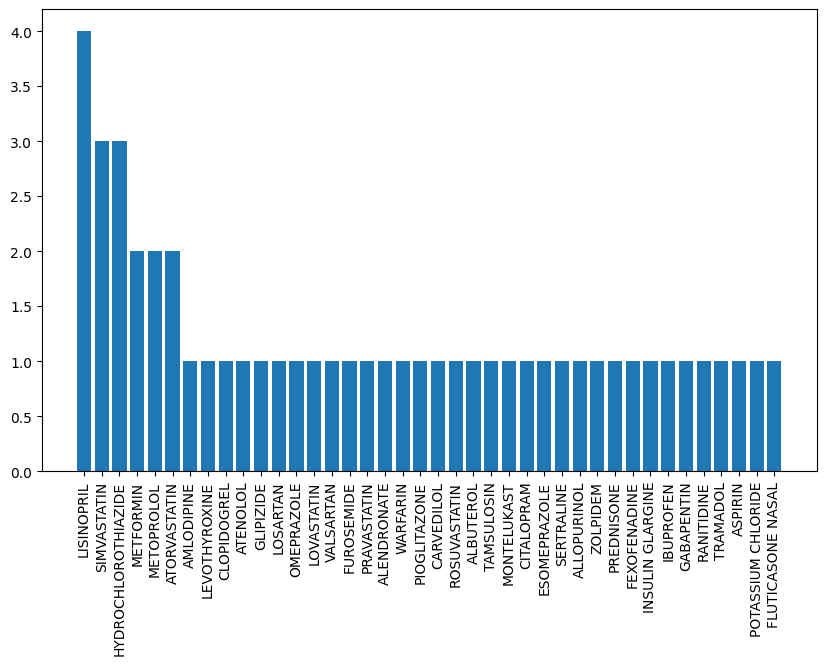

In [42]:
def get_machine_counts(total_number_of_machines, barplot_freq_of_drug_sorted: np.array):
    machines = [1] * 40
    left_number_of_machines = total_number_of_machines - np.sum(machines)
    # barplot_freq_of_drug_sorted = barplot_freq_of_drug_sorted - np.min(barplot_freq_of_drug_sorted)

    total_freq = np.sum(barplot_freq_of_drug_sorted)

    machine_rates = barplot_freq_of_drug_sorted / total_freq
    print(np.round(left_number_of_machines * machine_rates, 2))
    print('Total number of machines: ', np.sum(machines + np.round(left_number_of_machines * machine_rates)))
    return machines + np.round(left_number_of_machines * machine_rates)

# get_machine_counts(50, barplot_freq_of_drug_sorted)

plt.figure(figsize=(10, 6))
plt.bar(all_40_drugs_sorted, get_machine_counts(52, barplot_freq_of_drug_sorted))
plt.xticks(rotation=90)
plt.show()


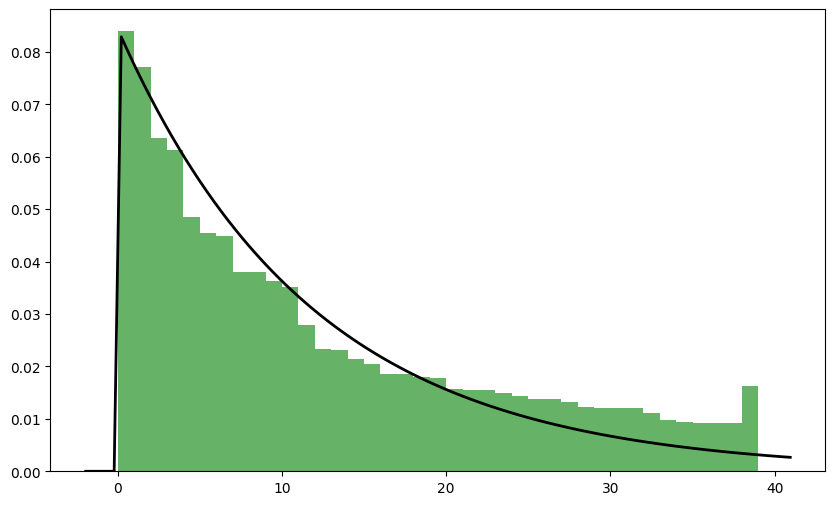

In [19]:
from scipy.stats import expon

# Fit a expon distribution to the data:
params = expon.fit(all_the_drugs)
params

# Plot the histogram.
plt.figure(figsize=(10, 6))
plt.hist(all_the_drugs, bins=39, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)
plt.plot(x, p, 'k', linewidth=2)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, 'LISINOPRIL'),
  Text(1, 0, 'SIMVASTATIN'),
  Text(2, 0, 'HYDROCHLOROTHIAZIDE'),
  Text(3, 0, 'METFORMIN'),
  Text(4, 0, 'METOPROLOL'),
  Text(5, 0, 'ATORVASTATIN'),
  Text(6, 0, 'AMLODIPINE'),
  Text(7, 0, 'LEVOTHYROXINE'),
  Text(8, 0, 'CLOPIDOGREL'),
  Text(9, 0, 'ATENOLOL'),
  Text(10, 0, 'GLIPIZIDE'),
  Text(11, 0, 'LOSARTAN'),
  Text(12, 0, 'OMEPRAZOLE'),
  Text(13, 0, 'LOVASTATIN'),
  Text(14, 0, 'VALSARTAN'),
  Text(15, 0, 'FUROSEMIDE'),
  Text(16, 0, 'PRAVASTATIN'),
  Text(17, 0, 'ALENDRONATE'),
  Text(18, 0, 'WARFARIN'),
  Text(19, 0, 'PIOGLITAZONE'),
  Text(20, 0, 'CARVEDILOL'),
  Text(21, 0, 'ROSUVASTATIN'),
  Text(22, 0, 'ALBUTEROL'),
  Text(23, 0, 'TAMSULOSIN'),
  Text(24, 0, 'MONTELUKAST'),
  Text(25, 0, 'CITALOPRAM'),
  Text(26, 0

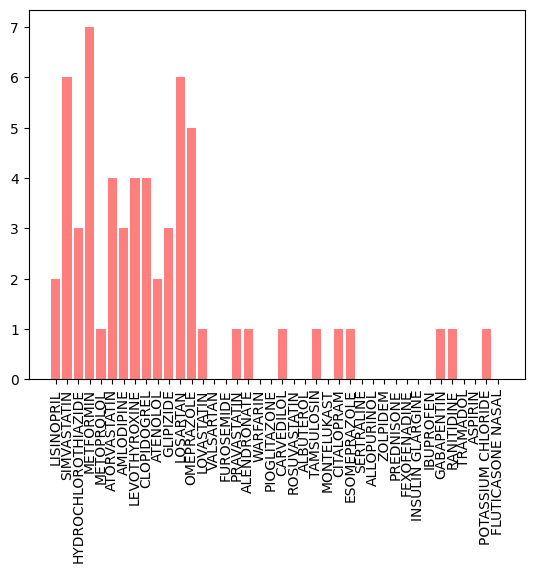

In [28]:
# generate 60 samples (from 0 to 40) from the fitted distribution
samples = expon.rvs(*params, size=60)
# from 0 to 40
samples = [int(i) % 40 for i in samples]


# add the samples to the barplot
barplot_freq_of_drug_sorted_2 = np.zeros(40)
for i in samples:
    barplot_freq_of_drug_sorted_2[i] += 1
plt.bar(all_40_drugs_sorted, barplot_freq_of_drug_sorted_2, color='r', alpha=0.5)
plt.xticks(rotation=90)


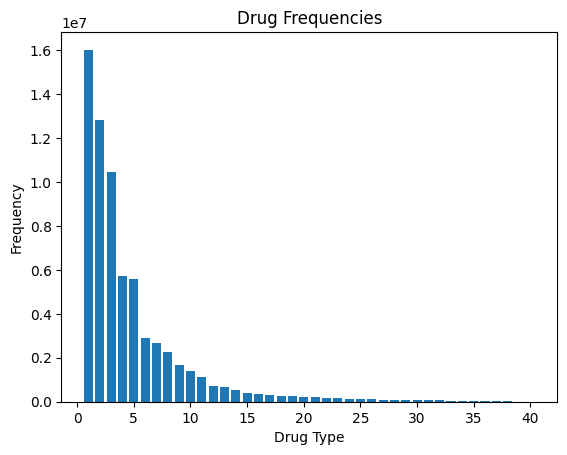

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4]
Drug Assignment to Machines:
Machine 1: Drug 1
Machine 2: Drug 1
Machine 3: Drug 2
Machine 4: Drug 3
Machine 5: Drug 4
Machine 6: Drug 4
Machine 7: Drug 5
Machine 8: Drug 6
Machine 9: Drug 7
Machine 10: Drug 8
Machine 11: Drug 9
Machine 12: Drug 10
Machine 13: Drug 11
Machine 14: Drug 11
Machine 15: Drug 12
Machine 16: Drug 13
Machine 17: Drug 14
Machine 18: Drug 15
Machine 19: Drug 16
Machine 20: Drug 17
Machine 21: Drug 18
Machine 22: Drug 18
Machine 23: Drug 18
Machine 24: Drug 18
Machine 25: Drug 19
Machine 26: Drug 19
Machine 27: Drug 19
Machine 28: Drug 19
Machine 29: Drug 20
Machine 30: Drug 21
Machine 31: Drug 22
Machine 32: Drug 23
Machine 33: Drug 24
Machine 34: Drug 25
Machine 35: Drug 26
Machine 36: Drug 27
Machine 37: Drug 28
Machine 38: Drug 28
Machine 39: Drug 29
Machine 40: Drug 30
Machine 41: Drug 31
Machine 42: Drug 32
Machine 43: Drug 33
Machine 44

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# Step 1: Fit the exponential distribution to the drug frequencies
# drug_frequencies = np.random.exponential(scale=10, size=40)
# drug_frequencies.sort()
drug_frequencies = barplot_freq_of_drug_sorted

# Plot the drug frequencies to visualize the distribution
plt.bar(range(1, 41), drug_frequencies)
plt.xlabel('Drug Type')
plt.ylabel('Frequency')
plt.title('Drug Frequencies')
plt.show()

# Estimate the rate parameter (lambda)
lambda_est = 1 / np.mean(drug_frequencies)

# Step 2: Calculate expected frequencies
total_machines = 50
expected_frequencies = expon.rvs(scale=1 / lambda_est, size=40)

# Normalize the expected frequencies to ensure they sum up to 60
expected_frequencies = expected_frequencies / expected_frequencies.sum() * total_machines
# print(expected_frequencies)

expected_frequencies = np.floor(expected_frequencies).astype(int)
expected_frequencies = [1 if i == 0 else i for i in expected_frequencies]
# print(expected_frequencies)
# print sorted
print(np.sort(expected_frequencies).tolist())


# Adjust the sum to be exactly 60
# while expected_frequencies.sum() < total_machines:
#     expected_frequencies[np.argmax(expected_frequencies)] += 1
# while expected_frequencies.sum() > total_machines:
#     expected_frequencies[np.argmax(expected_frequencies)] -= 1

# Step 3: Assign drugs to machines based on the expected frequencies
assignment = []
for drug, count in enumerate(expected_frequencies):
    assignment.extend([drug + 1] * count)

# Print the assignment
print("Drug Assignment to Machines:")
for i, drug in enumerate(assignment):
    print(f"Machine {i + 1}: Drug {drug}")

In [31]:
expected_frequencies

[2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1]

In [94]:
# In total we can have 60 machines. Each machine have 1 drug. There are 40 drugs in total. Based on histogram decide how many machines we need for each drug. 

# barplot_freq_of_drug_sorted
# freq1 + freq2 + freq3 + ... + freq40 = 60

def get_machine_frequences(total_number_of_machines, max_number_of_machines_per_drug, barplot_freq_of_drug_sorted):
    # total_number_of_machines is sum of all machines
    # max_number_of_machines_per_drug is the maximum number of machines that can be assigned to a single drug
    # barplot_freq_of_drug_sorted is the sorted list of frequencies of each drug
    # return the list of machines assigned to each drug
    machines = [0] * 40
    total_freq = sum(barplot_freq_of_drug_sorted)
    for i in range(40):
        machines[i] = int(barplot_freq_of_drug_sorted[i] / total_freq * total_number_of_machines)
        if machines[i] > max_number_of_machines_per_drug:
            machines[i] = max_number_of_machines_per_drug
        if machines[i] == 0:
            machines[i] = 1

    while sum(machines) > total_number_of_machines:
        argmax_idx = machines.__len__() - np.argmax(machines[::-1]) - 1
        machines[argmax_idx] -= 1
        # print('argmax_idx: ', argmax_idx, np.argmax(machines[::-1]))
        # plt.bar(all_40_drugs_sorted, machines)
        # plt.show()

    difference = total_number_of_machines - sum(machines)
    print('difference: ', difference)
    # if 
    return machines


In [95]:
get_machine_frequences(60, 10, barplot_freq_of_drug_sorted)

sum(get_machine_frequences(60, 10, barplot_freq_of_drug_sorted))

difference:  0
difference:  0


60

In [97]:
plottt

[5,
 5,
 5,
 4,
 4,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

difference:  0


<BarContainer object of 40 artists>

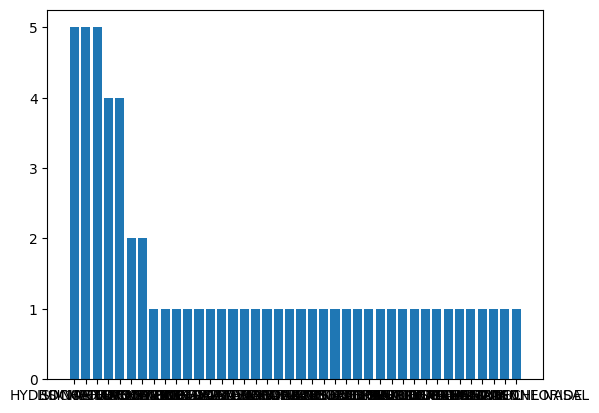

In [96]:
plottt = get_machine_frequences(60, 10, barplot_freq_of_drug_sorted)
plt.bar(all_40_drugs_sorted, plottt)

In [43]:
heatmap = np.zeros((40, 40))
for i in data.iterrows():
    combination = i[1]['drug_names']
    exact_exposure_count = 100 if i[1]['exact_exposure_count'] == '<100' else i[1]['exact_exposure_count']
    for drug1 in combination:
        for drug2 in combination:
            if drug1 in all_40_drugs and drug2 in all_40_drugs:
                heatmap[all_40_drugs.index(drug1)][all_40_drugs.index(drug2)] += int(exact_exposure_count)

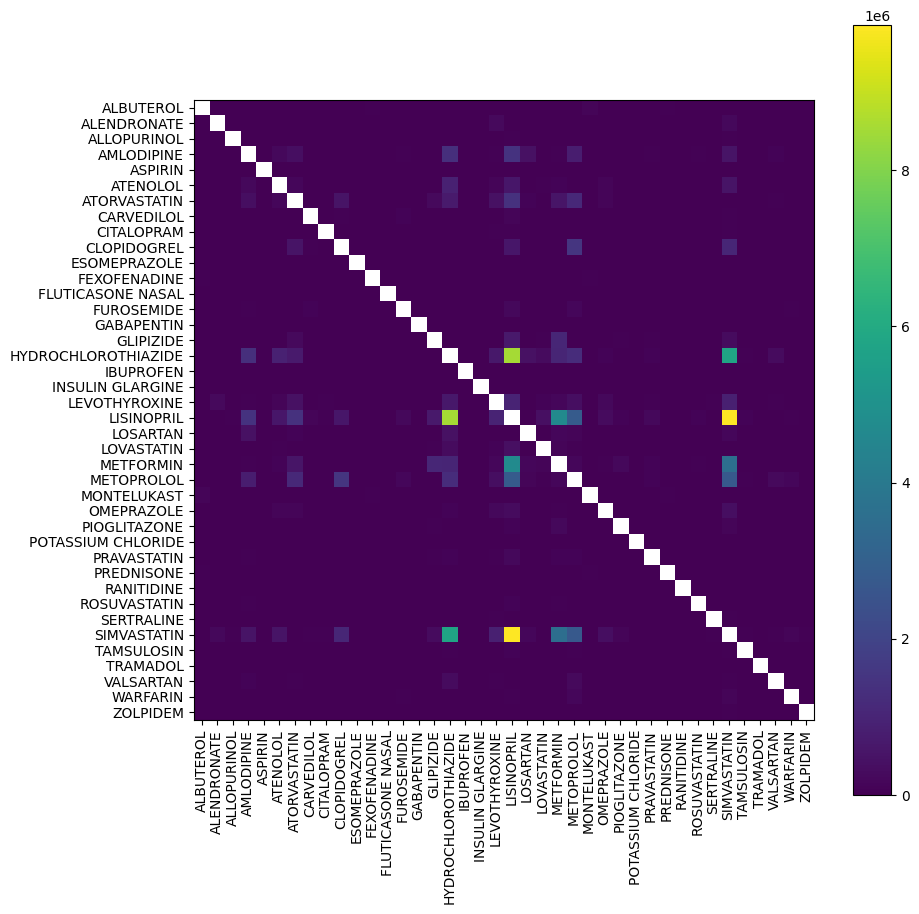

In [44]:
# heatmap_to_show = sorted_new.copy()
heatmap_to_show = heatmap.copy()

plt.figure(figsize=(10, 10))
heatmap_to_show[range(40), range(40)] = np.nan
plt.imshow(heatmap_to_show, cmap='viridis')
plt.colorbar()

plt.xticks(np.arange(40), [x.upper() for x in all_40_drugs], rotation=90)
plt.yticks(np.arange(40), [x.upper() for x in all_40_drugs])
plt.show()